In [1]:
import pandas as pd
import numpy as np
from selenium import webdriver
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use("ggplot")

In [2]:
import yfinance as yf

def daily_returns(data : pd.Series) -> float:
    '''
        Function to calculate daily returns from daliy price data
    '''
    return(data - data.shift(1))/data.shift(1)

def tracking_error(benchmark : pd.Series, portfolio : pd.Series) -> float:
    '''
        Function to compute tracking error
    '''
    return (portfolio - benchmark).std()

# Portfolio

Creating the portfolio class

In [3]:
class Portfolio:
    '''
        The portfolio class will mimic our investment over time.
    '''
    def __init__(self, target: str,
                tickerlist: list,
                investment: int = 1000,
                rebalance : int = 0,
                reconstitute : int = 1) -> None:
        '''
            Initialise portfolio
        '''
        self.target = target
        self.tickers = tickerlist
        
        self.start_nav = investment
        self.prevday_nav = investment
        self.current_nav = investment
        self.dividents = np.array([0.0]*len(tickerlist))                  # ignore dividents for now
        self.returns = self.get_returns()
        
        self.weights = pd.Series([1]*len(tickerlist), index=tickerlist)   # Equally balanced portfolio. Should Contain number of stocks owned. Ideally, Whole Numbers
        self.last_rebalancing_date = pd.to_datetime("01-01-1990")         # First rebalancing at 01st, Jan
        self.rebalancing_interval = rebalance - 1                         # in month (plus 1, because that month included)
        self.last_reconstitution_date = pd.to_datetime("01-01-1990")      # First reconstitution at 01st, Jan
        self.reconstitution_interval = reconstitute                       # in years
        pass

    def isUpdateAllowed(self, date: pd.Timestamp, mode : str = "rebalance") -> bool:
        '''
            Calculate Number of months between two dates
        '''
        diff = False
        if mode == "rebalance":
            diff = (date.year - self.last_rebalancing_date.year)*12 + date.month - self.last_rebalancing_date.month
            diff = diff >= self.rebalancing_interval
        elif mode == "reconstitute":
            diff = (date.year - self.last_reconstitution_date.year)*12 + date.month - self.last_rebalancing_date.month
            diff = diff >= self.reconstitution_interval
        return diff

    def reconstitute(self, price, date = None) -> None:
        '''
            Function to Reconstitute our portfolio.
            Checks:
                - weights updated only after "Reconstitution" period has passed
        '''
        date = price.index[0] if date is None else date
        if self.isUpdateAllowed(date= date, mode="reconstitute"):
            self.last_reconstitution_date = date
            # Convert weights to number of shares in portfolio
            self.rebalance(weights=price)
        else:
            raise Exception("Reconstitution Interval not passed.\n\t\
                            Last Reconstituted on: {last_recons}\n\t\
                            Requesting Reconstitution on: {curr_recons}".format(last_recons = self.last_reconstitution_date.strftime("%d-%b-%Y"),
                                                                        curr_recons = date.strftime("%d-%b-%Y")))
        pass

    def rebalance(self, price, date: pd.Timestamp = None) -> None:
        '''
            Function to update the Number of shares held by our portfolio.
            Checks:
                - Do ticker lists match?
                - weights updated only after "rebalance" period has passed
        '''
        price = price.fillna(0)
        
        if self.isUpdateAllowed(date= date, mode="rebalance"):
            difference_set = {x for x in price.index if x not in set(self.tickers)}
            if len(difference_set) == 0:

                if self.target != "DJIA":
                    price["cap"] = price["shares"]*price["close"]
                    nav = sum(price["cap"])
                else:
                    price["cap"] = price["close"]
                    nav = sum(price["cap"])
                # Convert weights to number of shares in portfolio
                # First the current NAV is calculated at close of day, then the portfolio is rebalenced
                if self.last_rebalancing_date != pd.to_datetime("01-01-1990"):
                    self.prevday_nav = self.current_nav
                    self.current_nav = self.weights.multiply(price["close"]).sum()
                self.weights = (((price["cap"]/nav)*self.current_nav)/price["close"])
                self.last_rebalancing_date = date
            else:
                raise Exception(" Input and Portfolio Tickers Not Matching. Net mismatch: {mismatch}\n".format(mismatch = len(difference_set))+", ".join(list(difference_set))); 
        else:
            raise Exception("rebalance Interval not passed.\n\t\
                            Last rebalanced on: {last_rebal}\n\t\
                            Requesting rebalance on: {curr_rebal}".format(last_rebal = self.last_rebalancing_date.strftime("%d-%b-%Y"),
                                                                        curr_rebal = date.strftime("%d-%b-%Y")))
        pass

    def net_return(self) -> float:
        return ((self.current_nav - self.start_nav + sum(self.dividents))/(self.start_nav))
        
    def get_returns(self) -> float:
        '''
        function to calculate returns of our portfolio
        '''
        return ((self.current_nav - self.prevday_nav + sum(self.dividents))/(self.prevday_nav))

    def echo(self) -> None:
        print("Target Index:",self.target)
        print("Starting Investment:",self.start_nav)
        print("Current Investment:",self.current_nav)
        print("Net Returns:", self.returns,"%")
        print("Constituent Indices:", ", ".join(self.tickers[0:5]+["\b\b ..."]))
        print("Constituent Weights:", self.weights[0:5])
        pass

# DJIA Replicating Portfolio

## Fetch DJIA Index Constituent Data

In [4]:
# # Create webdriver object
# webDriverLocation = '../../utils/chromedriver'
# driver = webdriver.Chrome(executable_path = webDriverLocation)

# # Get the website
# url = "https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average"
# driver.get(url)

# def get_text(x):
#     return x.text

In [5]:
# xpath = '//*[@id="constituents"]/tbody/tr/td[2]/a'
# djia_ticker_set = set()
# for item in driver.find_elements_by_xpath(xpath=xpath):
#     djia_ticker_set.add(get_text(item))
# print(len(djia_ticker_set))
# driver.close()
# # djia_ticker_set

In [6]:
# with open('./data/djia_ticker.txt', 'w') as f:
#     for item in djia_ticker_set:
#         f.write("%s\n" % item)

## Read DJIA Index Constituent Data

In [7]:
djia_ticker_set = set()
with open('./data/djia_ticker.txt') as f:
    djia_ticker_set = f.readlines()
    djia_ticker_set = {x.strip() for x in djia_ticker_set}
print(len(djia_ticker_set))

30


Fetch data from WRDS using the  list

***

## Read Daily Stock data from WRDS

### Desciption:

- GVKEY: Company Code ?
- IID  : Issue ID - Dividents ?
- DATADATE: Date
- TIC: Company Ticker
- CUSIP: Company CUSIP Code
- CONM : Company Name
- CSHOC : Shares Outstanding
- CSHTRD : Trading Volume
- PRCCD : Price Close Daily
- PRCHD : Price High Daily
- PRCLD : Price Low Daily
- PRCOD : Price Open Daily
- TRFD  : Total Return Factor Daily
- EXCHG : Stock Exchange Code
- BUSDESC : S&P Business Description
- GGROUP : GIC Groups
- GIND : GIC Industries
- GSECTOR : GIC Sector
- GSUBIND : GIC Sub-Industry

**Looking at stocks since 01 Jan 2010**

In [30]:
complete_df = pd.read_csv("./data/djia_dataset.csv"
                    ,low_memory= False)

djia_data = complete_df[["datadate","tic","prccd"]].copy()\
                                                .sort_values(by= "datadate")\
                                                .rename({'prccd':'close'}, axis = 1).\
                                                reset_index(drop=True)
djia_data["datadate"] = pd.to_datetime(djia_data["datadate"])
djia_data = djia_data[djia_data["datadate"] >= pd.to_datetime("12-31-2010")].sort_values(by="datadate")
djia_data = djia_data[djia_data["tic"].apply(lambda x: (x in djia_ticker_set))]

print("Number of unique tickers:",len(djia_data.tic.value_counts()))
print("Dimensions: ",djia_data.shape)
print("NULL count:\n",djia_data.isna().sum())
djia_data

Number of unique tickers: 30
Dimensions:  (79294, 3)
NULL count:
 datadate    0
tic         0
close       0
dtype: int64


,datadate,tic,close
108800,2010-12-31,INTC,21.03
108787,2010-12-31,MRK,36.04
108785,2010-12-31,CVX,91.25
108784,2010-12-31,KO,65.77
108783,2010-12-31,BA,65.26
...,...,...,...
85716,2021-10-08,MCD,247.70
85717,2021-10-08,CRM,272.48
85718,2021-10-08,DOW,58.71
85710,2021-10-08,HON,217.70


In [31]:
djia_data = djia_data.set_index(["datadate","tic"])
djia_data

close
datadate   tic         
2010-12-31 INTC   21.03
           MRK    36.04
           CVX    91.25
           KO     65.77
           BA     65.26
...                 ...
2021-10-08 MCD   247.70
           CRM   272.48
           DOW    58.71
           HON   217.70
           NKE   152.48

[79294 rows x 1 columns]

In [32]:
market_calendar_dates = sorted(list(set(map(lambda x: x[0],djia_data.index.values))))
market_calendar_dates[0:5]

[Timestamp('2010-12-31 00:00:00'),
 Timestamp('2011-01-03 00:00:00'),
 Timestamp('2011-01-04 00:00:00'),
 Timestamp('2011-01-05 00:00:00'),
 Timestamp('2011-01-06 00:00:00')]

## Executing Portfolio

In [47]:
djia_portfolio = Portfolio(target="DJIA",
                        tickerlist= list(djia_ticker_set), investment= 1000000,
                        rebalance=4, reconstitute=12)

djia_portfolio.echo()

Target Index: DJIA
Starting Investment: 1000000
Current Investment: 1000000
Net Returns: 0.0 %
Constituent Indices: CSCO, HON, PG, HD, MMM ...
Constituent Weights: CSCO    1
HON     1
PG      1
HD      1
MMM     1
dtype: int64


In [48]:
portfolio_val = pd.Series([], dtype=float)
portfolio_returns = pd.Series([], dtype=float)

for dates in market_calendar_dates:
    tmpdf = djia_data.loc[dates,:]
    if djia_portfolio.isUpdateAllowed(dates):
        djia_portfolio.rebalance(date= dates, price = tmpdf)
        portfolio_val[dates] = djia_portfolio.current_nav
        portfolio_returns[dates] = djia_portfolio.get_returns()

In [49]:
print("Net return since start: ",djia_portfolio.net_return()*100,"%")

Net return since start:  149.6332134449889 %


In [50]:
from scipy.stats.mstats import gmean
print("daily return: ",(gmean(portfolio_returns+1)-1)*100,"%")

daily return:  2.1009068012552756 %


## DJIA Index, ETF and Mutual Fund(Not yet available)

In [51]:
data = yf.download("^DJI DIA VTSMX", start="2010-12-31", end="2021-10-07")
data = data["Close"].loc[portfolio_returns.index]
data.head()


[*********************100%***********************]  3 of 3 completed


,DIA,VTSMX,^DJI
Date,,,
2010-12-31,115.629997,31.559999,11577.509766
2011-03-01,120.370003,32.869999,12058.019531
2011-06-01,122.699997,33.230000,12290.139648
2011-09-01,114.870003,30.180000,11493.570312
2011-12-01,120.129997,31.129999,12020.030273


In [52]:
baseline_return = data.apply(daily_returns).fillna(0)
baseline_return.head()

,DIA,VTSMX,^DJI
Date,,,
2010-12-31,0.000000,0.000000,0.000000
2011-03-01,0.040993,0.041508,0.041504
2011-06-01,0.019357,0.010952,0.019250
2011-09-01,-0.063814,-0.091785,-0.064814
2011-12-01,0.045791,0.031478,0.045805


## Plot

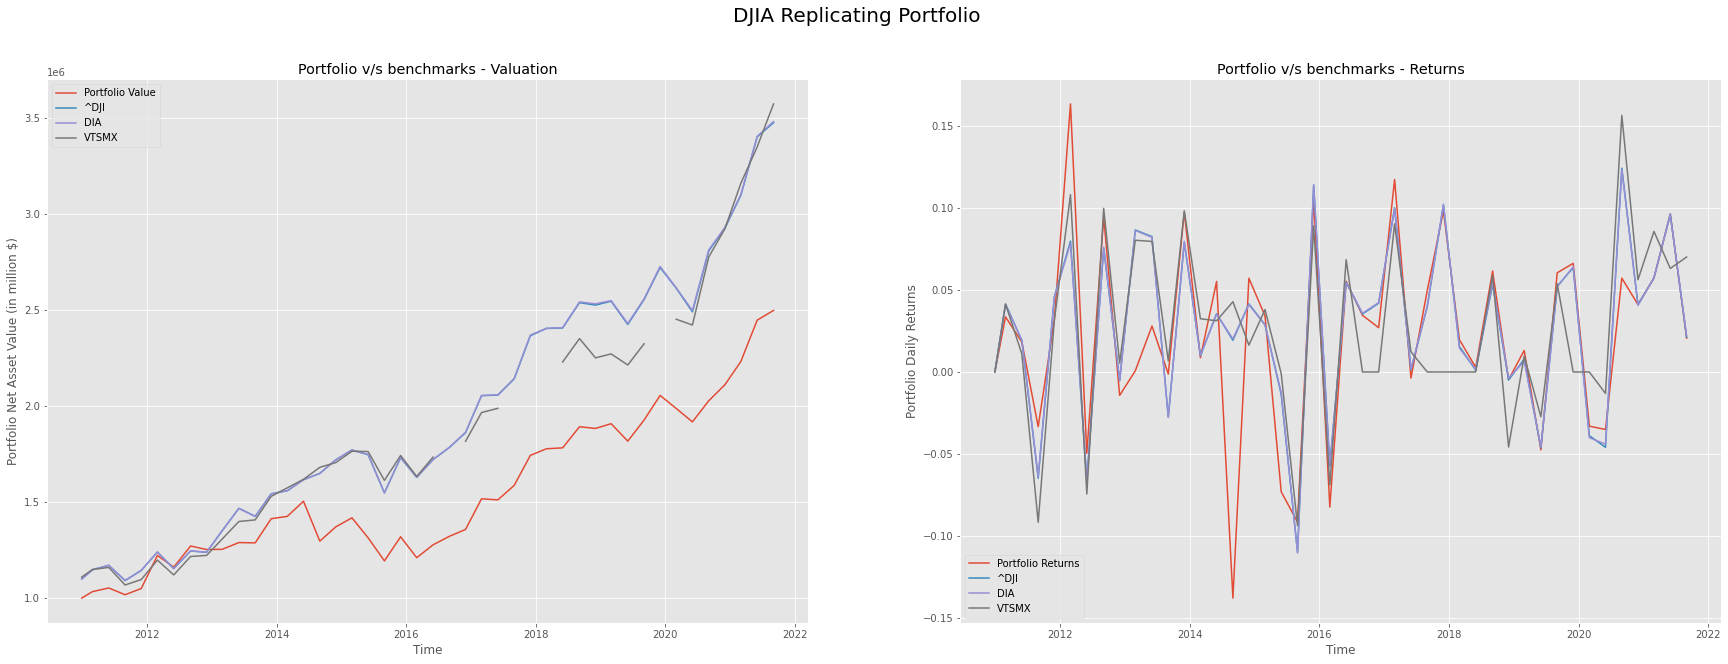

In [53]:
fig, ax = plt.subplots(1,2, sharex= False, sharey=False)
fig.set_size_inches(30, 10,  forward=True)

ax[0].plot(portfolio_val)
ax[0].plot((data["^DJI"]-584)*100)
ax[0].plot((data["DIA"]-5.66)*10000)
ax[0].plot(data["VTSMX"]*30000 + 162700)
ax[0].legend(["Portfolio Value","^DJI","DIA","VTSMX"])
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Portfolio Net Asset Value (in million $)")
ax[0].set_title("Portfolio v/s benchmarks - Valuation")

ax[1].plot(portfolio_returns)
ax[1].plot(baseline_return["^DJI"])
ax[1].plot(baseline_return["DIA"])
ax[1].plot(baseline_return["VTSMX"])
ax[1].legend(["Portfolio Returns","^DJI","DIA","VTSMX"])
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Portfolio Daily Returns")
ax[1].set_title("Portfolio v/s benchmarks - Returns")

fig.suptitle('DJIA Replicating Portfolio',fontsize=20);

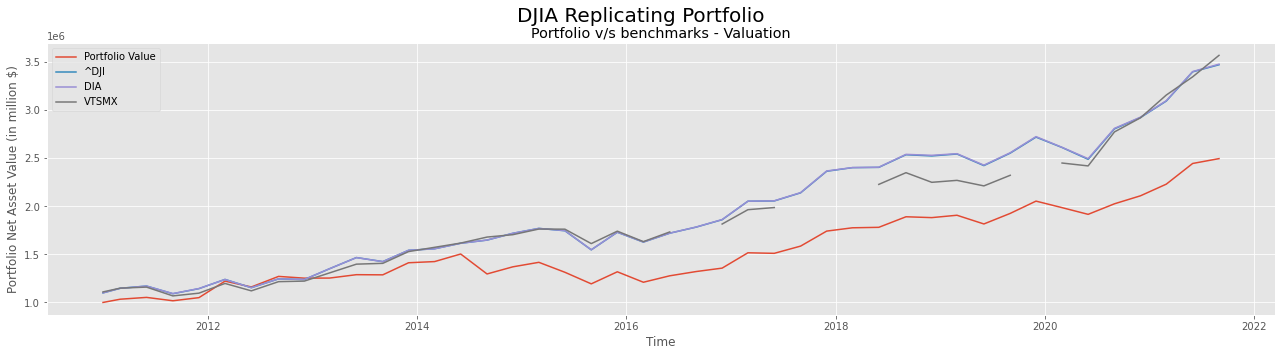

In [54]:
fig, ax = plt.subplots(1,1, sharex= False, sharey=False)
fig.set_size_inches(22, 5,  forward=True)

ax.plot(portfolio_val)
ax.plot((data["^DJI"]-584)*100)
ax.plot((data["DIA"]-5.66)*10000)
ax.plot(data["VTSMX"]*30000 + 162700)
ax.legend(["Portfolio Value","^DJI","DIA","VTSMX"])
ax.set_xlabel("Time")
ax.set_ylabel("Portfolio Net Asset Value (in million $)")
ax.set_title("Portfolio v/s benchmarks - Valuation")

fig.suptitle('DJIA Replicating Portfolio',fontsize=20);

In [55]:
tracking_error_djia = baseline_return.apply(lambda x: (tracking_error(portfolio_returns,x)))
for index, value in tracking_error_djia.iteritems():
    print("Tracking error between our portfolio and {target} is {std}%".format(target = index, std = str(round(value,5)*100)))

Tracking error between our portfolio and DIA is 3.5909999999999997%
Tracking error between our portfolio and VTSMX is 4.721%
Tracking error between our portfolio and ^DJI is 3.58%


In [56]:
baseline_return["Portfolio"] = portfolio_returns
annualised_mean_returns = baseline_return.mean()*4
print("Annualised mean returns")
annualised_mean_returns

Annualised mean returns


DIA          0.108322
VTSMX        0.102088
^DJI         0.108121
Portfolio    0.090988
dtype: float64

In [57]:
annualised_std_returns = baseline_return.std()*2
print("Annualised std returns")
annualised_std_returns

Annualised std returns


DIA          0.105829
VTSMX        0.108276
^DJI         0.106109
Portfolio    0.119610
dtype: float64

***
***